In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt


from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

%matplotlib inline

In [3]:
import os
files = []


my_path = os.getcwd()
for dirname, _, filenames in os.walk(my_path +'/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)
        files.append(file)
        print(file)

/Users/artem/Documents/self_education/RFM Segmentation and K-means Clustering/input/Year 2010-2011.csv
/Users/artem/Documents/self_education/RFM Segmentation and K-means Clustering/input/online_retail_II.xlsx
/Users/artem/Documents/self_education/RFM Segmentation and K-means Clustering/input/Year 2009-2010.csv


In [4]:
df = pd.read_excel(files[1])

# Checking the data

In [5]:
df.shape

(525461, 8)

In [6]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [7]:
df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


* Negative values probably means returned products
* comparing 75% quantile and max, we can found out outliers

In [8]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
df.Invoice.nunique()
# a number of unique invoices

28816

In [10]:
df.StockCode.nunique()
# a number of unique products

4632

In [11]:
df.Description.nunique()
# a number of unique customers

4681

In [12]:
df.Country.nunique()
# we have customers across 40 countries

40

# Data Preprocessing

In [13]:
df.isnull().sum().sort_values(ascending=False)

Customer ID    107927
Description      2928
Invoice             0
StockCode           0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

we have a number of zeroe values in dataset

## Correlation check

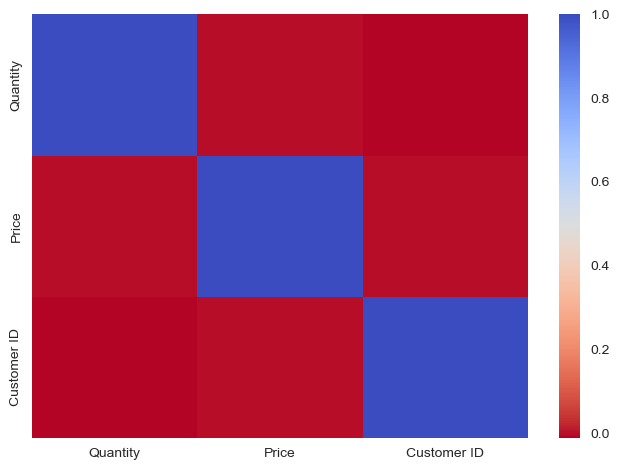

In [14]:
corrDF = df.corr()
sns.heatmap(corrDF,
            xticklabels=corrDF.columns,
            yticklabels=corrDF.columns, cmap ='coolwarm_r'
           );

There is no correlation

## Dropping negative values

In [15]:
df = df[(df['Quantity']>0)&(df['Price']>0)]
df.describe()

,Quantity,Price,Customer ID
count,511566.000000,511566.000000,407664.000000
mean,11.400150,4.252563,15368.592598
std,86.761177,63.664629,1679.762138
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13997.000000
50%,3.000000,2.100000,15321.000000
75%,10.000000,4.210000,16812.000000
max,19152.000000,25111.090000,18287.000000


In [16]:
df.shape

(511566, 8)

## Removing duplicates

In [17]:
df = df.drop_duplicates()
df.shape

(504731, 8)

# RFM analysis

The first step is to assign Recency, Frequency and Monetary values to each customer. 

Recency : It is the amount of time since the customers most recent transaction. It is measured in days.

Frequency: Total number of transactions made by the customer.

Monetary : Total amount the customer has spent across all transactions.


To calculate the Recency value, we need to find the last invoice date in our dataset.

In [18]:
df.InvoiceDate.max()

Timestamp('2010-12-09 20:01:00')

In [19]:
# A column for total cost
df['Amount'] = df['Quantity'] * df['Price']

In [20]:
pin_date = dt.datetime(2010, 12, 10)

In [21]:
rfm = df.groupby("Customer ID").agg({'InvoiceDate': lambda InvoiceDate:(pin_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.count(),
                                     'Amount': lambda Amount: Amount.sum()})
rfm.head()

,InvoiceDate,Invoice,Amount
Customer ID,,,
12346.0,164,33,372.86
12347.0,2,71,1323.32
12348.0,73,20,222.16
12349.0,42,102,2671.14
12351.0,10,21,300.93


In [22]:
rfm.isnull().sum()

InvoiceDate    0
Invoice        0
Amount         0
dtype: int64

## Changing the column names

In [23]:
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,164,33,372.86
12347.0,2,71,1323.32
12348.0,73,20,222.16
12349.0,42,102,2671.14
12351.0,10,21,300.93


## Calculate the score

We need to assign score from 1 to 5 for each customer
5 will be the highest, 1 will be the least
* The higher the monetray value, higher is the score 
* Smaller the value of recency, higher the score
* Higher the freuency, higher the score

In [32]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])


rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['score']=rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)

In [33]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score
Customer ID,,,,,,,
12346.0,164,33,372.86,2,3,2,7
12347.0,2,71,1323.32,5,4,4,13
12348.0,73,20,222.16,2,2,1,5
12349.0,42,102,2671.14,3,4,5,12
12351.0,10,21,300.93,5,2,2,9


## Best Customers

In [34]:
rfm[rfm['score']== 15].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score
Customer ID,,,,,,,
18102.0,0,627,349164.35,5,5,5,15
14646.0,9,1773,248396.50,5,5,5,15
14156.0,6,2646,196549.74,5,5,5,15
14911.0,0,5568,152121.22,5,5,5,15
13694.0,8,957,131443.19,5,5,5,15


The customers having a score of '15' are considered as the 'best customers' as they have have the highest recency, frequency and monetary score.

They are asset to the company.m

## Seggregate the levels

We are going to seggregate the level of the customer based on the score.

Here we have classified them into 4 levels.

Active : High revenue generating and frequent buyers .

Good: Customers whose purchases are fairly frequent and generate moderate revenue.

Average : Customers who are less active and are not very frequent buyers and generate low revenue.

Inactive: Customers generating very low revenue and are occasional buyers.

In [35]:
def rfm_level(score):
    if  ((score >1) and (score < 4)):
        return 'Inactive'
    elif ((score >3) and (score < 8)):
        return 'Average'
    elif ((score > 7) and (score <11)):
        return 'Good'
    else:
        return 'Active'

In [36]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,score,level
Customer ID,,,,,,,,
12346.0,164,33,372.86,2,3,2,7,Average
12347.0,2,71,1323.32,5,4,4,13,Active
12348.0,73,20,222.16,2,2,1,5,Average
12349.0,42,102,2671.14,3,4,5,12,Active
12351.0,10,21,300.93,5,2,2,9,Good


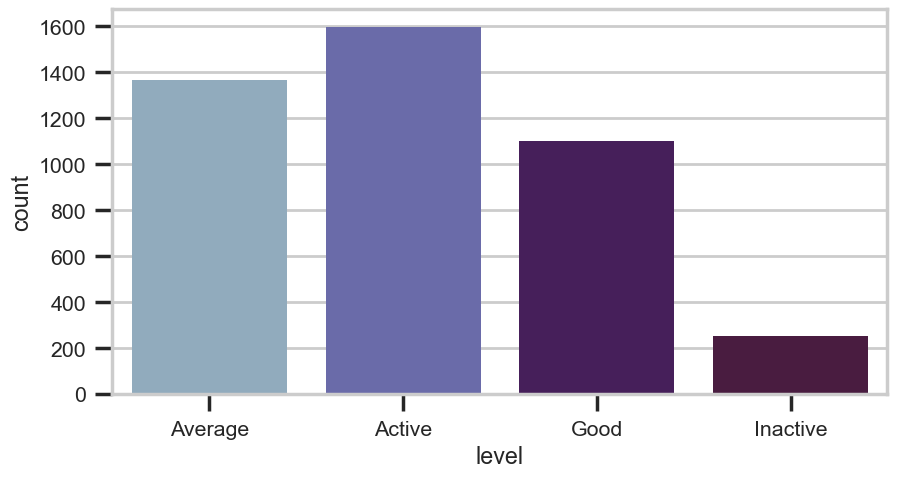

In [38]:
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(rfm['level']);

To understand each segment better, we will go deeper

### Analysis of each level

In [39]:
rfm.groupby('level').agg({
    'recency':['mean', 'min', 'max'],
    'frequency':['mean', 'min', 'max'],
    'monetary':['mean', 'min', 'max'],
})

recency             frequency               monetary          \
                mean  min  max        mean min   max         mean     min   
level                                                                       
Active     26.706583    0  216  199.421944   6  5568  4490.811730  287.91   
Average   146.492308    0  373   19.977289   1   111   368.305547    3.75   
Good       71.246588    0  373   49.000000   1   258  1000.271303   75.76   
Inactive  268.636364  176  373    6.790514   1    14   131.833202    2.95   

                     
                max  
level                
Active    349164.35  
Average    13916.34  
Good       34095.26  
Inactive     250.26

## Visualizing against each of the factors

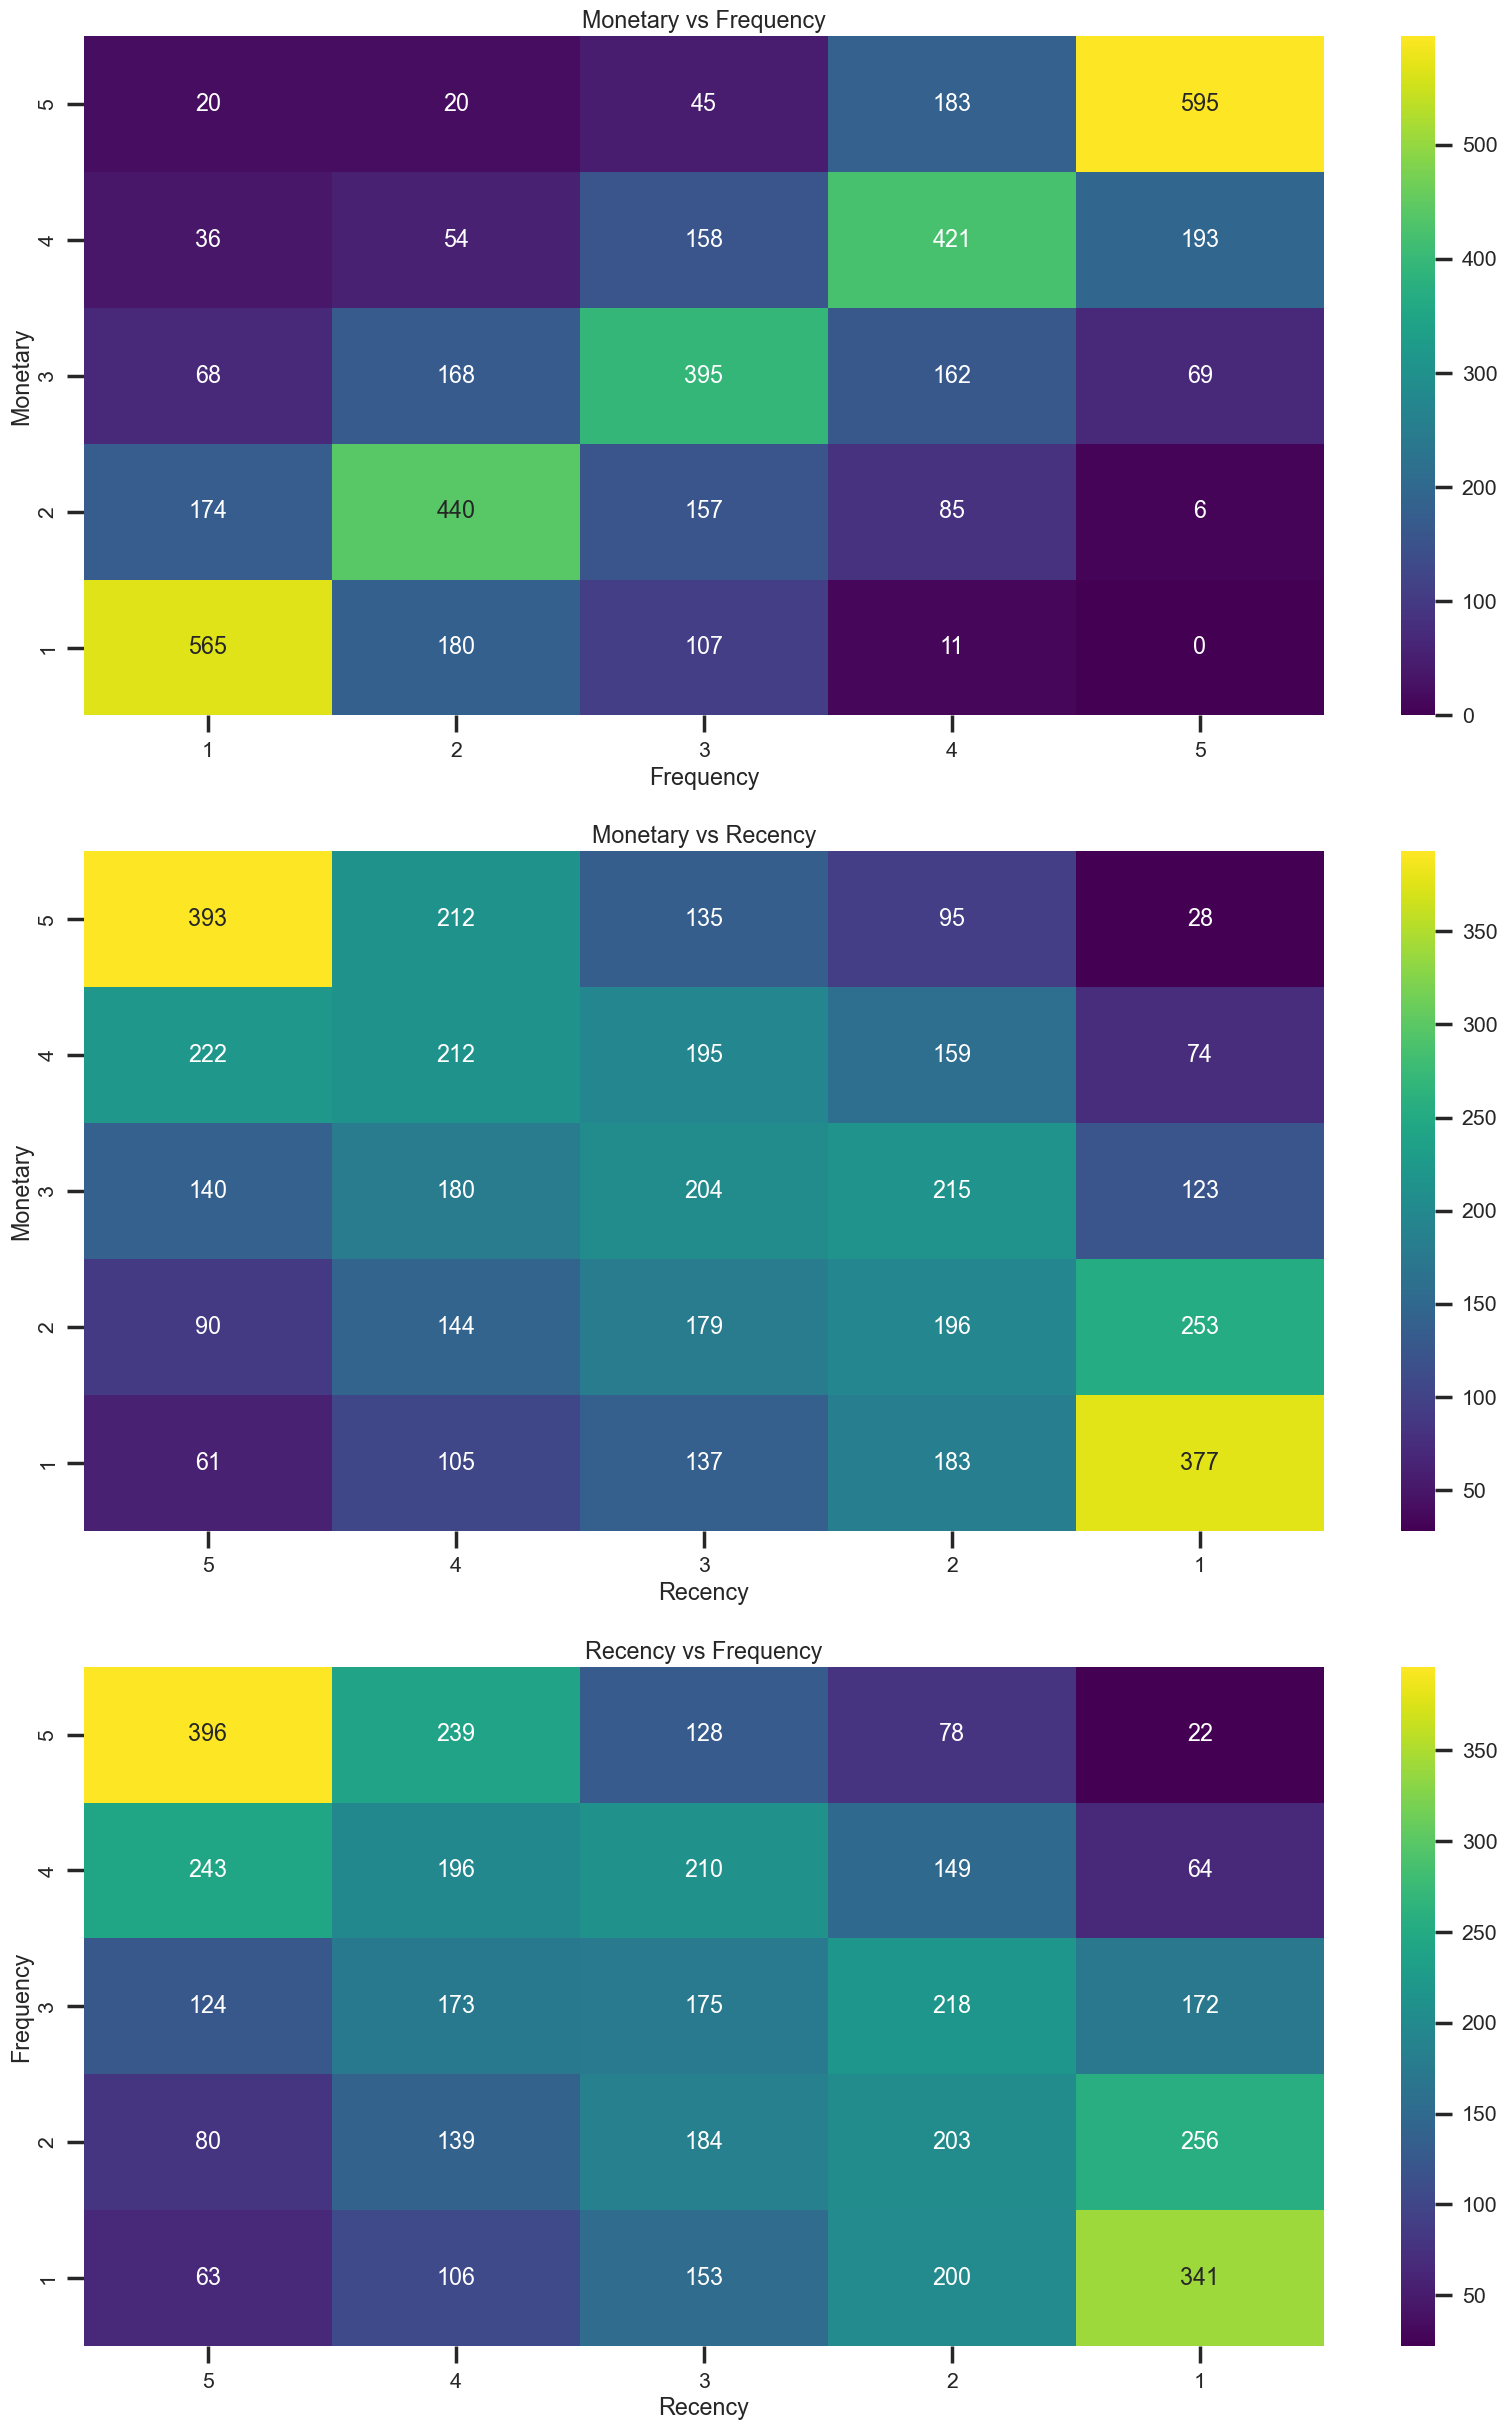

In [41]:
cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

# RFM Clustering

In [40]:
rfm.describe()

,recency,frequency,monetary,score
count,4312.000000,4312.000000,4312.000000,4312.000000
mean,90.172542,92.976809,2040.406712,9.024814
std,96.861457,198.909265,8911.755977,3.563727
min,0.000000,1.000000,2.950000,3.000000
25%,17.000000,18.000000,307.187500,6.000000
50%,52.000000,43.000000,701.615000,9.000000
75%,135.000000,100.000000,1714.932500,12.000000
max,373.000000,5568.000000,349164.350000,15.000000


There are no negative values, so we will check outliers

### Outlier treatment for recency

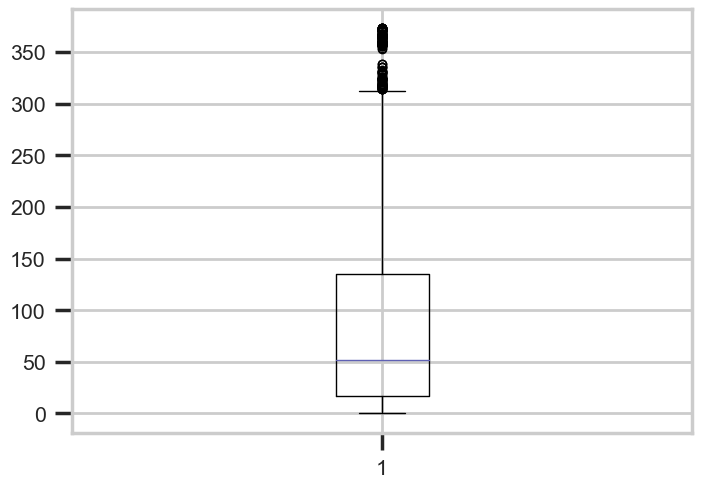

In [43]:
plt.boxplot(rfm.recency)
Q1 = rfm.recency.quantile(0.25)
Q3 = rfm.recency.quantile(0.75)
IQR = Q3-Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

### Outlier treatment for frequency¶

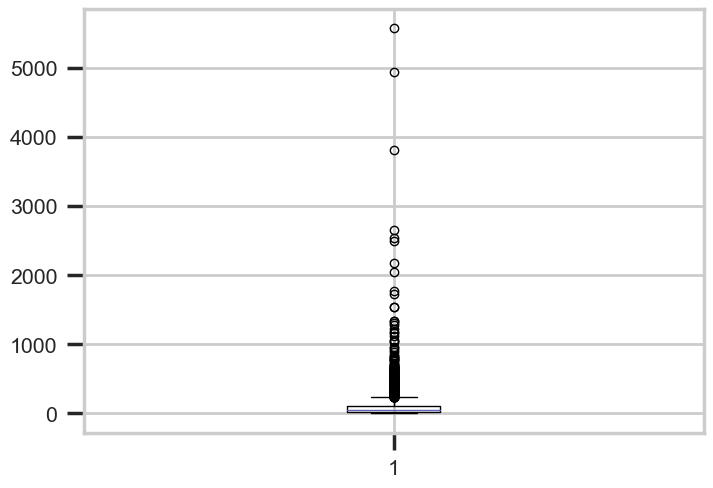

In [44]:
plt.boxplot(rfm.frequency)
Q1 = rfm.frequency.quantile(0.25)
Q3 = rfm.frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

### Outlier treatment for monetary

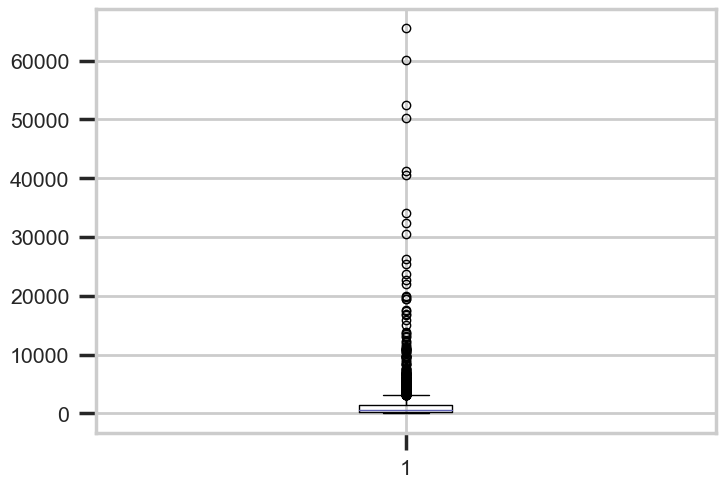

In [45]:
plt.boxplot(rfm.monetary)
Q1 = rfm.monetary.quantile(0.25)
Q3 = rfm.monetary.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary >= (Q1 - 1.5*IQR)) & (rfm.monetary <= (Q3 + 1.5*IQR))]